# Quantitative and Categorical Data for EDA and Price Analysis


We are performing an inner join based on UUID, then drop null values.

 **There might be concerns here**: null values might be due to rules, and will exclude the majority of cards.
 - Power: only for creatures
 - toughness: only for creatures
 - Color Identity: not for instants and spells
 - Salthines: arbitraty opinion
 
 We cannot make general claims about the data when we know it is not general


In [27]:
# Load necessary libraries
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns
from matplotlib import gridspec
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

sns.set()

In [88]:
# Card info
cards_csv = pd.read_csv('../dataset/cards.csv', sep=";")
prices_csv = pd.read_csv('../dataset/cardPrices.csv', sep=",")


# Just to test we are using Creatures as our analysis 
all_data = pd.merge(prices_csv, cards_csv, on="uuid")


# Attributes that will always be null because their are based on game rules
rule_based_attributes = ['power', 'toughness', 'colorIdentity', 'colors', 'supertypes']
subset = all_data.columns.difference(rule_based_attributes)

all_data.dropna(subset=subset, inplace=True)
data = all_data.reset_index(drop=True)
print(f"Number of NA values: \n{all_data.isnull().sum()} \n")


mapped_data = data.select_dtypes(include=['number'])
label_encoder = LabelEncoder()

# one-hot categorical data for general analysis
to_encode = ['rarity', 'artist', 'finishes', 'currency','hasFoil' , 'supertypes',
             'hasNonFoil',  'gameAvailability', 'priceProvider', 'setCode', 'type']
for enc in to_encode:    
    mapped_data[enc] = label_encoder.fit_transform(data[enc])

Number of NA values: 
cardFinish              0
currency                0
date                    0
gameAvailability        0
price                   0
priceProvider           0
providerListing         0
uuid                    0
artist                  0
colorIdentity       13654
colors              14852
edhrecRank              0
edhrecSaltiness         0
finishes                0
hasFoil                 0
hasNonFoil              0
isReprint               0
language                0
layout                  0
manaCost                0
manaValue               0
name                    0
number                  0
originalType            0
power               57312
rarity                  0
setCode                 0
sourceProducts          0
supertypes          96203
toughness           57312
type                    0
types                   0
dtype: int64 



In [89]:
# Update mapped file
mapped_data.to_csv('../dataset/mapped_data.csv', index=False)
mapped_data.head()

,price,edhrecRank,edhrecSaltiness,manaValue,rarity,artist,finishes,currency,hasFoil,supertypes,hasNonFoil,gameAvailability,priceProvider,setCode,type
0,0.15,8596.0,0.07,2.0,0,656,2,1,0,4,1,0,0,142,628
1,0.34,8596.0,0.07,2.0,0,656,2,1,0,4,1,0,0,142,628
2,0.25,8596.0,0.07,2.0,0,656,2,1,0,4,1,1,4,142,628
3,0.42,8596.0,0.07,2.0,0,656,2,0,0,4,1,1,2,142,628
4,0.59,8596.0,0.07,2.0,0,656,2,1,0,4,1,1,1,142,628


In [90]:
# Remove outliers to anbalyze prices
def removeOutliers(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
 
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    outlier_free_list = [x for x in data[col] if ((x > lower_range) & (x < upper_range))]
    filtered_data = data.loc[data[col].isin(outlier_free_list)]
    return filtered_data

mapped_data = removeOutliers(mapped_data, 'price')


In [91]:
# normalize the data
scaler = MinMaxScaler()
norm_data = pd.DataFrame(scaler.fit_transform(mapped_data), columns=mapped_data.columns)

display(norm_data.head())

,price,edhrecRank,edhrecSaltiness,manaValue,rarity,artist,finishes,currency,hasFoil,supertypes,hasNonFoil,gameAvailability,priceProvider,setCode,type
0,0.040936,0.30714,0.020134,0.166667,0.0,0.759259,0.666667,1.0,0.0,1.0,1.0,0.0,0.00,0.642534,0.661053
1,0.096491,0.30714,0.020134,0.166667,0.0,0.759259,0.666667,1.0,0.0,1.0,1.0,0.0,0.00,0.642534,0.661053
2,0.070175,0.30714,0.020134,0.166667,0.0,0.759259,0.666667,1.0,0.0,1.0,1.0,1.0,1.00,0.642534,0.661053
3,0.119883,0.30714,0.020134,0.166667,0.0,0.759259,0.666667,0.0,0.0,1.0,1.0,1.0,0.50,0.642534,0.661053
4,0.169591,0.30714,0.020134,0.166667,0.0,0.759259,0.666667,1.0,0.0,1.0,1.0,1.0,0.25,0.642534,0.661053


In [92]:
import statsmodels.api as sm

X = mapped_data.loc[:, ~mapped_data.columns.isin(['price'])]
y = mapped_data["price"]

model = sm.OLS(y, X)    # Describe model

result = model.fit()       # Fit model

print(result.summary()) 

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.503
Model:                            OLS   Adj. R-squared (uncentered):              0.503
Method:                 Least Squares   F-statistic:                              6990.
Date:                Sun, 06 Oct 2024   Prob (F-statistic):                        0.00
Time:                        15:00:49   Log-Likelihood:                         -85162.
No. Observations:               89758   AIC:                                  1.704e+05
Df Residuals:                   89745   BIC:                                  1.705e+05
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [96]:
fstat, pvalue = sm.stats.linear_rainbow(result)
print(f' f stat: {fstat} | p value: {pvalue}')

 f stat: 0.8715681007156081 | p value: 0.9999999999999999


# Interpretation of results (NEED REVISION)

#### R-squared and Adjusted R-squared
- **R-squared (0.576)**: This indicates that approximately **57.6%** of the variability in card prices can be explained by the independent variables included in the model. This suggests a moderate level of explanatory power.
  
- **Adjusted R-squared (0.575)**: This value adjusts for the number of predictors in the model, confirming that the model's explanatory power remains consistent even after accounting for additional variables.

#### F-statistic and Prob (F-statistic)
- **F-statistic (646.3)**: A high F-statistic indicates that at least one predictor variable significantly contributes to explaining the variability in price.
  
- **Prob (F-statistic) (0.00)**: This p-value indicates that the overall regression model is statistically significant, meaning that the independent variables collectively have a significant effect on card prices.

The OLS regression results suggest several factors significantly influence card prices, including EDHREC saltiness, mana value, rarity, and whether the card is foil or not:

- The negative impact of rarity on price may indicate market dynamics where rarer cards are less frequently sold or valued differently.
  
- The positive relationship between EDHREC saltiness and price suggests that cards perceived as more desirable or playable are valued higher by collectors and players.

---

# Linear Regression Prediction

In [97]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression model and use it based on selected feature and target
def prediction(feature, target):
    X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=42)
    
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    model = LinearRegression().fit(X_train_poly, y_train)
    
    y_pred = model.predict(X_test_poly)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return y_test, y_pred, mse, r2

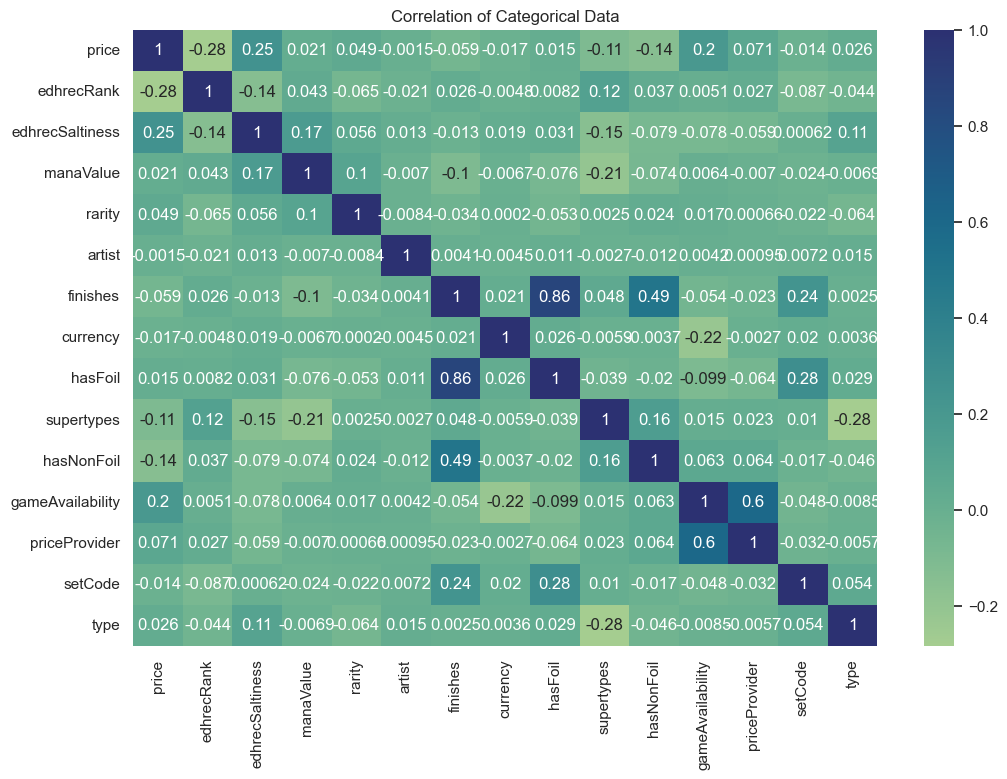

In [98]:

plt.figure(figsize=(12,8))
sns.heatmap(mapped_data.corr(),annot=True, cmap="crest")
plt.title("Correlation of Categorical Data")
plt.show()

Mean Squared Error: 0.3294891573565296
R-squared: 0.2808402004287285


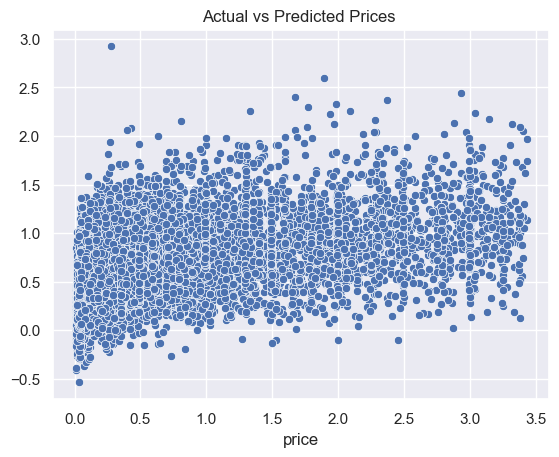

In [99]:
import statsmodels.api as sm
# Price Prediction based on Rank

X = mapped_data.loc[:, ~mapped_data.columns.isin(['price'])]
y = mapped_data["price"]

# Polinomial Linear Regression
y_test, y_pred, mse, r2 = prediction(X, y)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Ploting results
sns.scatterplot(x=y_test, y=y_pred)
plt.title(f'Actual vs Predicted Prices ')
plt.show()